In [9]:
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras import models

from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [83]:
TRAIN_DATA_DIR = 'data/final_ver2.1/train/'
TEST_DATA_DIR = 'data/final_ver2.1/test/'

TRAIN_NEGATIVE_DATA_DIR = 'data/final_ver2.1/train_negative/'
TEST_NEGATIVE_DATA_DIR = 'data/final_ver2.1/test_negative/'

train_fire_size = []
test_fire_size = []

train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []
train_file = []

test_X = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []
test_file = []

#pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
#pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

TRAIN_DATA_DIR = 'data/ver1/train3/final_positive/'
TEST_DATA_DIR = 'data/ver1/test3/final_positive/'

TRAIN_NEGATIVE_DATA_DIR = 'data/ver1/train3/final_negative/'
TEST_NEGATIVE_DATA_DIR = 'data/ver1/test3/final_negative/'

In [84]:
def padding(a, i) :
    if (a.shape[1] >= i) :
        return a[:, 0:i]
    else :
        difference = i-a.shape[1]
        zeros = np.random.randint(difference+1)
        
        #print(zeros, difference-zeros)
        
        first = np.zeros((a.shape[0], zeros))
        second = np.zeros((a.shape[0], difference - zeros))
        
        new = np.hstack((first, a))
        new = np.hstack((new, second))
        
        return new

In [85]:
for fname in os.listdir(TRAIN_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        train_file.append(TRAIN_DATA_DIR + fname)
        wav, sr = librosa.load(TRAIN_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        #train_fire_size.append(len(mfcc[0]))
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        train_mfccs.append(padded_mfcc)
        train_mel_spectrograms.append(padded_mel_spectrogram)
        train_y.append(1)
    except Exception as e:
        print(fname, e)
        raise

In [86]:
for fname in os.listdir(TEST_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        test_file.append(TEST_DATA_DIR + fname)
        wav, sr = librosa.load(TEST_DATA_DIR + fname, sr=16000)
        
        #if(len(wav) > 20000) :
         #   wav = librosa.effects.time_stretch(wav, 1.5)
            
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        test_fire_size.append(len(mfcc[0]))
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        
        test_mfccs.append(padded_mfcc)
        test_mel_spectrograms.append(padded_mel_spectrogram)
        test_y.append(1)
    except Exception as e:
        print(fname, e)
        raise

In [87]:
for fname in os.listdir(TRAIN_NEGATIVE_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        train_file.append(TRAIN_NEGATIVE_DATA_DIR + fname)
        wav, sr = librosa.load(TRAIN_NEGATIVE_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        train_mfccs.append(padded_mfcc)
        train_mel_spectrograms.append(padded_mel_spectrogram)
        train_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

In [88]:
for fname in os.listdir(TEST_NEGATIVE_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        test_file.append(TEST_NEGATIVE_DATA_DIR + fname)
        wav, sr = librosa.load(TEST_NEGATIVE_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        test_mfccs.append(padded_mfcc)
        test_mel_spectrograms.append(padded_mel_spectrogram)
        test_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

print(len(train_fire_size))
print(np.max(train_fire_size))
print(np.mean(train_fire_size))

print(len(test_fire_size))
print(np.max(test_fire_size))
print(np.mean(test_fire_size))

In [89]:
train_mfccs = np.array(train_mfccs)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_y = np.array(train_y)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_mel_spectrograms = np.array(test_mel_spectrograms)
test_y = np.array(test_y)
test_y = to_categorical(np.array(test_y))

print('train_mfccs', train_mfccs.shape)
print('train_mel_spectrograms', train_mel_spectrograms.shape)
print('train_y', train_y.shape)

print('test_mfccs', test_mfccs.shape)
print('test_mel_spectrograms', test_mel_spectrograms.shape)
print('test_y', test_y.shape)

train_mfccs (3600, 20, 63)
train_mel_spectrograms (3600, 128, 63)
train_y (3600, 2)
test_mfccs (900, 20, 63)
test_mel_spectrograms (900, 128, 63)
test_y (900, 2)


In [90]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (3600, 20, 63, 1)
test X shape: (900, 20, 63, 1)


In [91]:
train_X_ex_mel = np.expand_dims(train_mel_spectrograms, -1)
test_X_ex_mel = np.expand_dims(test_mel_spectrograms, -1)
print('train X shape:', train_X_ex_mel.shape)
print('test X shape:', test_X_ex_mel.shape)

train X shape: (3600, 128, 63, 1)
test X shape: (900, 128, 63, 1)


In [92]:
np.save(os.path.join("data/dataset", "train_X.npy"), train_X_ex)
np.save(os.path.join("data/dataset", "train_X_mel.npy"), train_X_ex_mel)
np.save(os.path.join("data/dataset", "train_file.npy"), train_file)
np.save(os.path.join("data/dataset", "train_y.npy"), np.array(train_y))

np.save(os.path.join("data/dataset", "test_X.npy"), test_X_ex)
np.save(os.path.join("data/dataset", "test_X_mel.npy"), test_X_ex_mel)
np.save(os.path.join("data/dataset", "test_file.npy"), test_file)
np.save(os.path.join("data/dataset", "test_y.npy"), np.array(test_y))

In [93]:
train_X_ex = np.load(os.path.join('data/dataset', 'train_X.npy'))
train_X_ex_mel = np.load(os.path.join('data/dataset', 'train_X_mel.npy'))
train_file = np.load(os.path.join('data/dataset', 'train_file.npy'))
train_y = np.load(os.path.join('data/dataset', 'train_y.npy'))

test_X_ex = np.load(os.path.join('data/dataset', 'test_X.npy'))
test_X_ex_mel = np.load(os.path.join('data/dataset', 'test_X_mel.npy'))
test_file = np.load(os.path.join('data/dataset', 'test_file.npy'))
test_y = np.load(os.path.join('data/dataset', 'test_y.npy'))

In [94]:
train_X_ex, train_X_ex_mel, train_y, train_file = shuffle(train_X_ex, train_X_ex_mel, train_y, train_file, random_state=1523)
test_X_ex, test_X_ex_mel, test_y, test_file = shuffle(test_X_ex, test_X_ex_mel, test_y, test_file, random_state=1523)

In [95]:
len(test_X_ex)

900

In [96]:
np.max(test_X_ex)

140.73544311523438

In [97]:
np.min(test_X_ex)

-347.41510009765625

In [98]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)


m=Flatten()(m)
m=Dense(32, activation='relu')(m)
op=Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 63, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 60, 64)        1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 15, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                122912    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 124,066
Trainable params: 124,066
Non-trainable params: 0
________________________________________________

In [99]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('model/train_X_ex_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

model.compile(optimizer=optimizers.Adam(learning_rate=0.000001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [100]:
history = model.fit(train_X_ex,
                    train_y,
                    epochs=200,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
111/113 [============================>.] - ETA: 0s - loss: 1.9641 - accuracy: 0.5414
Epoch 00001: val_loss improved from inf to 1.78851, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 12ms/step - loss: 1.9642 - accuracy: 0.5414 - val_loss: 1.7885 - val_accuracy: 0.5733
Epoch 2/200
109/113 [===========================>..] - ETA: 0s - loss: 1.7055 - accuracy: 0.5513
Epoch 00002: val_loss improved from 1.78851 to 1.61203, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 1.7038 - accuracy: 0.5511 - val_loss: 1.6120 - val_accuracy: 0.5911
Epoch 3/200
110/113 [============================>.] - ETA: 0s - loss: 1.5224 - accuracy: 0.5574
Epoch 00003: val_loss improved from 1.61203 to 1.48338, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 1.5200 - accuracy: 0.5575 - val_loss: 1.4834 - val_accuracy: 0.6011
Epoch 4/200
106/113 [=======

108/113 [===========================>..] - ETA: 0s - loss: 0.6957 - accuracy: 0.6924
Epoch 00026: val_loss improved from 0.83711 to 0.82974, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 10ms/step - loss: 0.6911 - accuracy: 0.6953 - val_loss: 0.8297 - val_accuracy: 0.6589
Epoch 27/200
109/113 [===========================>..] - ETA: 0s - loss: 0.6802 - accuracy: 0.6967
Epoch 00027: val_loss improved from 0.82974 to 0.82150, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 10ms/step - loss: 0.6824 - accuracy: 0.6956 - val_loss: 0.8215 - val_accuracy: 0.6567
Epoch 28/200
111/113 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.7007
Epoch 00028: val_loss improved from 0.82150 to 0.81140, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.6739 - accuracy: 0.7003 - val_loss: 0.8114 - val_accuracy: 0.6611
Epoch 29/200
113/113 [===========

113/113 [==============================] - 1s 9ms/step - loss: 0.5480 - accuracy: 0.7472 - val_loss: 0.7177 - val_accuracy: 0.6811
Epoch 52/200
111/113 [============================>.] - ETA: 0s - loss: 0.5453 - accuracy: 0.7466
Epoch 00052: val_loss improved from 0.71766 to 0.71381, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.5443 - accuracy: 0.7475 - val_loss: 0.7138 - val_accuracy: 0.6822
Epoch 53/200
109/113 [===========================>..] - ETA: 0s - loss: 0.5424 - accuracy: 0.7483
Epoch 00053: val_loss improved from 0.71381 to 0.71007, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.5409 - accuracy: 0.7503 - val_loss: 0.7101 - val_accuracy: 0.6811
Epoch 54/200
109/113 [===========================>..] - ETA: 0s - loss: 0.5353 - accuracy: 0.7514
Epoch 00054: val_loss improved from 0.71007 to 0.70996, saving model to model\train_X_ex_best.h5
113/113 [=============

113/113 [==============================] - 1s 9ms/step - loss: 0.4745 - accuracy: 0.7814 - val_loss: 0.6644 - val_accuracy: 0.7078
Epoch 78/200
113/113 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.7822
Epoch 00078: val_loss improved from 0.66444 to 0.66440, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.4723 - accuracy: 0.7822 - val_loss: 0.6644 - val_accuracy: 0.7078
Epoch 79/200
112/113 [============================>.] - ETA: 0s - loss: 0.4684 - accuracy: 0.7854
Epoch 00079: val_loss improved from 0.66440 to 0.66228, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.4710 - accuracy: 0.7844 - val_loss: 0.6623 - val_accuracy: 0.7067
Epoch 80/200
112/113 [============================>.] - ETA: 0s - loss: 0.4681 - accuracy: 0.7843
Epoch 00080: val_loss improved from 0.66228 to 0.66160, saving model to model\train_X_ex_best.h5
113/113 [=============

Epoch 00103: val_loss improved from 0.63565 to 0.63418, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.4261 - accuracy: 0.8092 - val_loss: 0.6342 - val_accuracy: 0.7133
Epoch 104/200
113/113 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8122
Epoch 00104: val_loss did not improve from 0.63418
113/113 [==============================] - 1s 9ms/step - loss: 0.4241 - accuracy: 0.8122 - val_loss: 0.6360 - val_accuracy: 0.7133
Epoch 105/200
109/113 [===========================>..] - ETA: 0s - loss: 0.4237 - accuracy: 0.8142
Epoch 00105: val_loss improved from 0.63418 to 0.63333, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.4228 - accuracy: 0.8131 - val_loss: 0.6333 - val_accuracy: 0.7144
Epoch 106/200
112/113 [============================>.] - ETA: 0s - loss: 0.4209 - accuracy: 0.8158
Epoch 00106: val_loss improved from 0.63333 to 0.63012, saving mo

Epoch 00129: val_loss improved from 0.61344 to 0.61047, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3898 - accuracy: 0.8344 - val_loss: 0.6105 - val_accuracy: 0.7200
Epoch 130/200
108/113 [===========================>..] - ETA: 0s - loss: 0.3878 - accuracy: 0.8377
Epoch 00130: val_loss improved from 0.61047 to 0.60873, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3882 - accuracy: 0.8356 - val_loss: 0.6087 - val_accuracy: 0.7211
Epoch 131/200
112/113 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8368
Epoch 00131: val_loss improved from 0.60873 to 0.60762, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3871 - accuracy: 0.8372 - val_loss: 0.6076 - val_accuracy: 0.7189
Epoch 132/200
107/113 [===========================>..] - ETA: 0s - loss: 0.3868 - accuracy: 0.8362
Epoch 00132: val_lo

Epoch 155/200
112/113 [============================>.] - ETA: 0s - loss: 0.3597 - accuracy: 0.8499
Epoch 00155: val_loss did not improve from 0.58969
113/113 [==============================] - 1s 9ms/step - loss: 0.3594 - accuracy: 0.8497 - val_loss: 0.5899 - val_accuracy: 0.7311
Epoch 156/200
108/113 [===========================>..] - ETA: 0s - loss: 0.3575 - accuracy: 0.8487
Epoch 00156: val_loss improved from 0.58969 to 0.58934, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3581 - accuracy: 0.8475 - val_loss: 0.5893 - val_accuracy: 0.7311
Epoch 157/200
105/113 [==========================>...] - ETA: 0s - loss: 0.3572 - accuracy: 0.8476
Epoch 00157: val_loss improved from 0.58934 to 0.58865, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3570 - accuracy: 0.8492 - val_loss: 0.5886 - val_accuracy: 0.7344
Epoch 158/200
108/113 [===========================>..] - ETA: 0s 

Epoch 182/200
111/113 [============================>.] - ETA: 0s - loss: 0.3320 - accuracy: 0.8618
Epoch 00182: val_loss improved from 0.57444 to 0.57399, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3318 - accuracy: 0.8617 - val_loss: 0.5740 - val_accuracy: 0.7411
Epoch 183/200
106/113 [===========================>..] - ETA: 0s - loss: 0.3309 - accuracy: 0.8638
Epoch 00183: val_loss improved from 0.57399 to 0.57374, saving model to model\train_X_ex_best.h5
113/113 [==============================] - 1s 9ms/step - loss: 0.3307 - accuracy: 0.8619 - val_loss: 0.5737 - val_accuracy: 0.7444
Epoch 184/200
110/113 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8628 ETA: 0s - loss: 0.3281 
Epoch 00184: val_loss did not improve from 0.57374
113/113 [==============================] - 1s 9ms/step - loss: 0.3300 - accuracy: 0.8625 - val_loss: 0.5749 - val_accuracy: 0.7389
Epoch 185/200
111/113 [==================

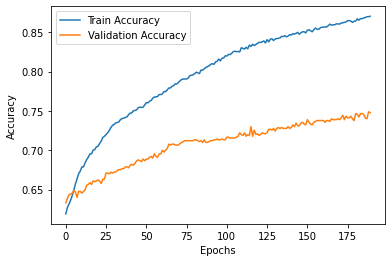

In [101]:
plt.plot(history.history['accuracy'][10:], label='Train Accuracy')
plt.plot(history.history['val_accuracy'][10:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

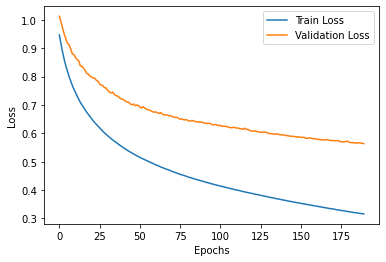

In [102]:
plt.plot(history.history['loss'][10:], label='Train Loss')
plt.plot(history.history['val_loss'][10:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

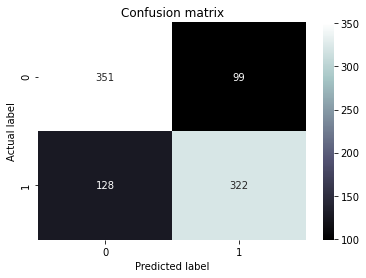

In [104]:
Y_pred = model.predict(test_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

matrix = confusion_matrix(np.argmax(test_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [119]:
best_model = models.load_model('model/train_X_ex_mel_best.h5')

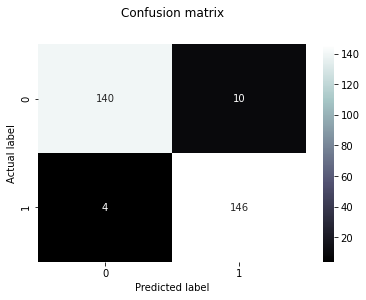

In [121]:
Y_pred = best_model.predict(test_X_ex_mel)
y_pred = np.argmax(Y_pred,axis=1)

matrix = confusion_matrix(np.argmax(test_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [43]:
y_pred

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,

In [44]:
np.argmax(test_y,axis=1)

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,

In [45]:
fn_result = []
fp_result = []
for n in range(0, len(test_y)):
    if y_pred[n] != np.argmax(test_y,axis=1)[n]:
        if(y_pred[n] == 1) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [46]:
print(len(fp_result))
print(len(fn_result))

47
16


In [47]:
for name in fp_result:
    print(test_file[name])

data/final/test_negative/0.17_bg_739_1.wav
data/final/test_negative/0.11_bg_969_30.wav
data/final/test_negative/0.88_bg_602_45.wav
data/final/test_negative/0.37_bg_1060_44.wav
data/final/test_negative/0.01_bg_861_44.wav
data/final/test_negative/0.46_bg_779_30.wav
data/final/test_negative/0.48_bg_881_15.wav
data/final/test_negative/0.57_bg_869_8.wav
data/final/test_negative/0.14_bg_650_32.wav
data/final/test_negative/0.29_bg_712_34.wav
data/final/test_negative/0.65_bg_769_22.wav
data/final/test_negative/0.06_bg_1005_13.wav
data/final/test_negative/0.03_bg_992_7.wav
data/final/test_negative/0.07_bg_849_35.wav
data/final/test_negative/0.13_bg_853_37.wav
data/final/test_negative/0.84_bg_785_34.wav
data/final/test_negative/0.68_bg_795_43.wav
data/final/test_negative/0.05_bg_715_36.wav
data/final/test_negative/0.33_bg_584_33.wav
data/final/test_negative/0.14_bg_728_42.wav
data/final/test_negative/0.14_bg_631_23.wav
data/final/test_negative/0.53_bg_770_23.wav
data/final/test_negative/0.53_bg_

In [48]:
import IPython.display

In [49]:
i = 0
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/final/test_negative/0.17_bg_739_1.wav
1


In [ ]:
i = 1
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [ ]:
i = 2
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [50]:
for name in fn_result:
    print(test_file[name])

data/final/test/0.24_bg_524_m3.wav
data/final/test/0.24_bg_1_dh1.wav
data/final/test/0.19_bg_467_dh26.wav
data/final/test/0.49_bg_189_dh1.wav
data/final/test/0.3_bg_466_dh25.wav
data/final/test/0.19_bg_361_dh11.wav
data/final/test/0.39_bg_209_dh25.wav
data/final/test/0.19_bg_21_dh26.wav
data/final/test/0.52_bg_23_dj12.wav
data/final/test/0.41_bg_75_dh27.wav
data/final/test/0.43_bg_62_dh16.wav
data/final/test/0.13_bg_74_dh26.wav
data/final/test/0.23_bg_299_dh27.wav
data/final/test/0.26_bg_179_f2.wav
data/final/test/0.24_bg_53_dh1.wav
data/final/test/0.66_bg_108_dh18.wav


In [55]:
i = -1
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/final/test/0.66_bg_108_dh18.wav
0


In [ ]:
i = 1
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [ ]:
i = 2
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [85]:
NON_DATA_DIR = 'data/resampling/non/'

extra_fire_X = []
extra_fire_spectrograms = []
extra_fire_mel_spectrograms = []
extra_fire_mfccs = []
extra_fire_y = []
extra_fire_file = []

for fname in os.listdir(NON_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        extra_fire_file.append(NON_DATA_DIR + fname)
        wav, sr = librosa.load(NON_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        
        padded_mfcc = pad2d(mfcc, 28)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = pad2d(mel_spectogram, 28)
        
        extra_fire_mfccs.append(padded_mfcc)
        extra_fire_mel_spectrograms.append(padded_mel_spectrogram)
        extra_fire_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

In [87]:
extra_fire_DATA_DIR = 'data/resampling/fire/'

for fname in os.listdir(extra_fire_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        extra_fire_file.append(extra_fire_DATA_DIR + fname)
        wav, sr = librosa.load(extra_fire_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        
        padded_mfcc = pad2d(mfcc, 28)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = pad2d(mel_spectogram, 28)
        
        extra_fire_mfccs.append(padded_mfcc)
        extra_fire_mel_spectrograms.append(padded_mel_spectrogram)
        extra_fire_y.append(1)
    except Exception as e:
        print(fname, e)
        raise
        
extra_fire_mfccs = np.array(extra_fire_mfccs)
extra_fire_mel_spectrograms = np.array(extra_fire_mel_spectrograms)
extra_fire_y = np.array(extra_fire_y)
extra_fire_y = to_categorical(np.array(extra_fire_y))

extra_fire_X_ex = np.expand_dims(extra_fire_mfccs, -1)
extra_fire_X_ex_mel = np.expand_dims(extra_fire_mel_spectrograms, -1)

In [88]:
extra_fire_X_ex.shape

(110, 20, 28, 1)

In [82]:
np.save(os.path.join("data/dataset", "extra_fire_X_ex.npy"), extra_fire_X_ex)
np.save(os.path.join("data/dataset", "extra_fire_X_ex_mel.npy"), extra_fire_X_ex_mel)
np.save(os.path.join("data/dataset", "extra_fire_file.npy"), extra_fire_file)
np.save(os.path.join("data/dataset", "extra_fire_y.npy"), np.array(extra_fire_y))

extra_fire_X_ex = np.load(os.path.join('data/dataset', 'extra_fire_X_ex.npy'))
extra_fire_X_ex_mel = np.load(os.path.join('data/dataset', 'extra_fire_X_ex_mel.npy'))
extra_fire_file = np.load(os.path.join('data/dataset', 'extra_fire_file.npy'))
extra_fire_y = np.load(os.path.join('data/dataset', 'extra_fire_y.npy'))

extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file = shuffle(extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file, random_state=1523)

In [89]:
best_model = models.load_model('model/train_X_ex_best.h5')

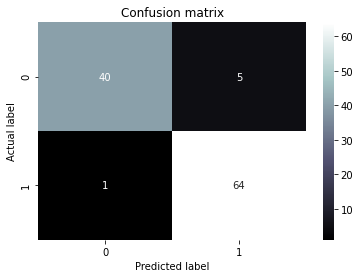

acc:  0.9454545454545454


In [90]:
#mfcc
Y_pred = best_model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [91]:
fn_result = []
fp_result = []
for n in range(0, len(extra_fire_y)):
    if y_pred[n] != np.argmax(extra_fire_y,axis=1)[n]:
        if(y_pred[n] == 0) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [92]:
print(len(fp_result))
print(len(fn_result))

1
5


In [93]:
for name in fp_result:
    print(extra_fire_file[name])

data/resampling/fire/dh17.wav


In [94]:
for name in fn_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [145]:
best_model = models.load_model('model/train_X_ex_mel_best.h5')

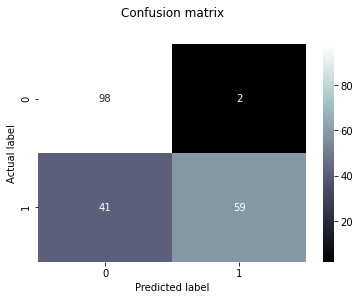

acc:  0.785


In [146]:
#mel spectrogram
Y_pred = best_model.predict(extra_fire_X_ex_mel)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [147]:
fn_result = []
fp_result = []
for n in range(0, len(extra_fire_y)):
    if y_pred[n] != np.argmax(extra_fire_y,axis=1)[n]:
        if(y_pred[n] == 0) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [148]:
print(len(fp_result))
print(len(fn_result))

41
2


In [97]:
for name in fp_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [96]:
i = 0
wav = extra_fire_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(extra_fire_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/resampling/fire/dh17.wav
0


In [98]:
for name in fn_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [100]:
i = 2
wav = extra_fire_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(extra_fire_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/resampling/non/34.wav
1


In [ ]:
y_pred

In [9]:
wav = 'non_tang.wav'
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)

wav shape:  (16030,)


In [13]:
#mfcc = librosa.feature.mfcc(y, sr=16000)
#padded_mfcc = pad2d(mfcc, 75)
mel_spectogram = librosa.feature.melspectrogram(y)
padded_mel_spectrogram = pad2d(mel_spectogram, 75)

In [14]:
test_mel_tang = np.array(padded_mel_spectrogram)
test_final = []
test_final.append(test_mel_tang)
test_final = np.expand_dims(test_final, -1)

In [15]:
test_final

(1, 128, 75, 1)

In [16]:
test_X_ex_mel.shape

(300, 128, 50, 1)

In [ ]:
Y_pred = model.predict(test_final)
y_pred = np.argmax(Y_pred,axis=1)

In [ ]:
y_pred